In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
import json
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer as NBA
from textblob.tokenizers import SentenceTokenizer as ST
from wordcloud import WordCloud, STOPWORDS

In [3]:
#Data obtained from https://github.com/bpb27/trump_tweet_data_archive

In [4]:
def vectorize(tweets):
    all_characters = ["{}".format(_) for tweet in tweets for _ in tweet]
    print("There are {} characters.".format(len(all_characters)))
    char_to_index = {u: i for i, u in enumerate(sorted(set(all_characters)))}

    vectorized = [[char_to_index[_] for _ in tweet] for tweet in tweets]
    return vectorized, char_to_index

In [5]:
def check_if_website(text):
    #Check for website:
    if text[:6] == "https:":
        website = True
    else:
        website = False
    return website


def remove_at_symbol(word):
    if word[0] == '@':
        return word[1:]
    else:
        return word


def separate_and_remove_special(text):
    text = "".join(
        [char for char in text if char not in ['“', '”'] and ord(char) < 128])
    #remove twitter's quotation characters.
    text_list = text.split(" ")
    #split the text into words to clean each word
    clean_string = []
    for word in text_list:
        if len(word) > 0:
            word = remove_at_symbol(word)
            website = check_if_website(word)
            if not website:
                clean_string.append(word)
    return " ".join(clean_string)


def parse_text(tweet):
    """
    Parse the message and only save it if it fits 
    the criteria:
        Not just a website link
    """
    website = check_if_website(tweet["text"])
    retweet = tweet["is_retweet"]
    #Remove the Retweet header if present
    if not website and not retweet:
        clean_string = separate_and_remove_special(tweet["text"])
        return clean_string
    else:
        return None

In [6]:
with open('condensed_2018.json') as f:
    tweets = json.load(f)
    print("There are {} tweets to parse.".format(len(tweets)))

There are 3510 tweets to parse.


In [7]:
clean_tweets = []
total_tweets = len(tweets)
for tweet in tweets:
    clean = parse_text(tweet)
    if clean != None:
        clean_tweets.append(clean)
print("There are {} usable tweets after removing {} \"bad\" tweets.".format(
    len(clean_tweets), total_tweets - len(clean_tweets)))

There are 2991 usable tweets after removing 519 "bad" tweets.


In [8]:
vectorized, char_to_index = vectorize(clean_tweets)
index_to_char = {v: k for k, v in char_to_index.items()}
print(vectorized[0], "--->",
      "".join([index_to_char[_] for _ in vectorized[0]]))

There are 578727 characters.
[39, 32, 47, 47, 56, 1, 45, 36, 54, 1, 56, 36, 32, 49, 2] ---> HAPPY NEW YEAR!


In [9]:
sentiment_list = []
nouns_list = []
verbs_list = []
adjectives_list = []
for clean in clean_tweets:
    tweet = TextBlob(clean, tokenizer=ST())
    for sub_tweet in tweet.tokens:
        sent = TextBlob(sub_tweet)
        for tag in sent.tags:
            if tag[1] in ["NN", "NNS", "NNP", "NNPS"]:
                nouns_list.append(tag[0])
                #nouns_list.append(tag[0].singularize())
        if not np.isclose(0.0, sent.sentiment[0]):
            sentiment_list.append([sent.sentiment[0], sent.sentiment[1]])
    #tweet = TextBlob(clean_tweets[i], analyzer=NaiveBayesAnalyzer())

In [10]:
sentiment_list = np.array(sentiment_list)

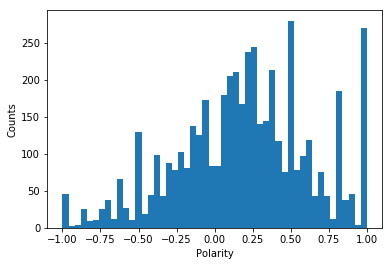

In [11]:
fig, ax = plt.subplots()
hist = ax.hist(sentiment_list[:, 0], bins=50)
txt = ax.set_xlabel("Polarity")
txt = ax.set_ylabel("Counts")
#hist = ax.hist(sentiment_list[:,1], bins = 30, alpha = 0.5)

In [14]:
def generate_cloud_mask():
    trump_mask = np.array(Image.open("trump_mask.png"))
    trump_mask[trump_mask >= 1] = 255
    trump_mask[trump_mask < 1] = 0.
    trump_mask = trump_mask * -1
    trump_mask = trump_mask + 255
    return trump_mask

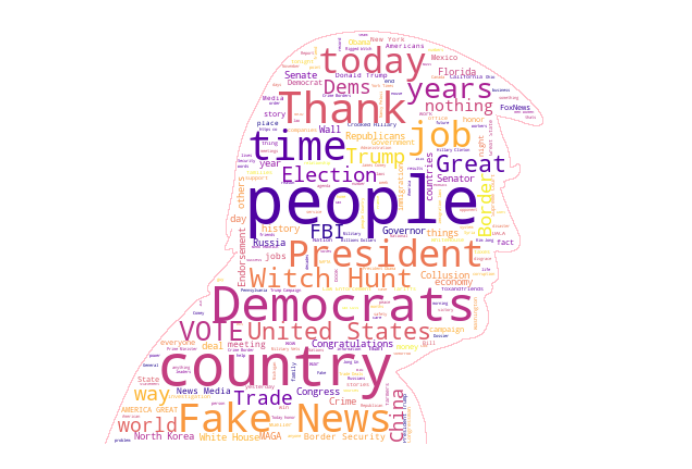

In [19]:
trump_mask = generate_cloud_mask()
ratio = trump_mask
mask_ratio = trump_mask.shape[1]/trump_mask.shape[0]
stopwords = set(STOPWORDS)
stopwords.add("amp")
wc = WordCloud(
    background_color="white",
    max_words=1000,
    mask=trump_mask,
    stopwords=stopwords,
    contour_width=0.01,
    contour_color="pink",
    colormap='plasma',
    #colormap = 'RdBu',
    normalize_plurals=False,
)
wc.generate(" ".join(nouns_list))
figsize = 8
fig, ax = plt.subplots(figsize=(figsize*mask_ratio, figsize))
ax.imshow(wc, interpolation='bilinear')
p = plt.axis("off")
plt.savefig("trump.png", bbox_inches="tight")